In [1]:
from __future__ import division, absolute_import

import os
import sys
import random

import numpy as np
import datetime

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

#from src.Target import Target

np.random.seed(8)
random.seed(8)

from src.preprocessing import *
from src.model_architecture import *
from src.training_model import *
from src.postprocessing import *
from src.comparing_results import *
#from src.callbacks import *
%matplotlib inline

Using TensorFlow backend.


### Defining parameters

In [2]:
list_paddings = ['post_padding', 'pre_padding', 'mid_padding', 'strf_padding', 'ext_padding', 
                 'rnd_padding', 'aug_padding']
list_padding_short = ['post_padding', 'pre_padding', 'mid_padding', 'strf_padding', 'ext_padding', 
                 'rnd_padding']
#hierarchy of folders: annotation/dataset/architecture/n_neurs/task/padding
folder = 'EC_number/archaea/3denses/bio_neurons/'
column = "EC number"

n_folds = 10

# Pre-processing

/home/angela/padding_EBI/src/preprocessing.py:36: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table(file_in,compression='gzip',sep='\t')


Max length: (9159, 505)


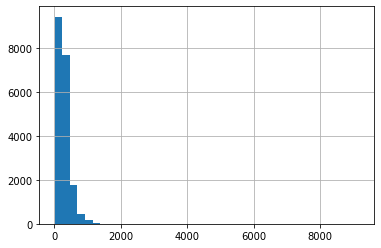

In [3]:
#loading data
file_in= "".join([absPath, 'raw_data/uniprot-reviewed_yes+AND+taxonomy_archaea-EC.tab.gz'])
df = loading_data(file_in, column)
#max len
max_len = looking_max_len(df)
print("Max length:", max_len)
#max_lenn = max_len[1]
max_lenn = 1000
#filtering
df_filt = filtering_over_maxlen(df, max_lenn)
dicti = creating_dict()

0        MIIGYFDGLCEPKNPGGIATFGFVIYLDNRKIEGYGLAEKPFSINS...
1        MIIEGEVVSGLGEGRYFLSLPPYKEIFKKILGFEPYEGTLNLKLDR...
2        MNINEILKKLINKSDLEINEAEELAKAIIRGEVPEILVSAILVALR...
3        MVVPLKRIDKIRWEIPKFDKRMRVPGRVYADEVLLEKMKNDRTLEQ...
4        MERAFIEWYPRGYGVAFKIKKKIYEKLSKYQKIEVYETEGFGRLLA...
5        MMMGVELAFPKVVGKQVYGSLYECDEDVLKDTKRLEQIIKEAADIG...
6        MPRLIKDRVPTPERSVGERVRDFGEVNLGYSWELALREAERCLQCP...
7        MGYNEQERAFIEWYPRGYGVGFKVKRRLFETQTEYQRLEIYETEGF...
8        MVDIVKRRDWEKKEKKKIAIERIDTLFTLAERVARYSPDLAKRYVE...
9        MNVEEMKKIAAKEALKFIEDDMVIGLGTGSTTAYFIKLLGEKLKRG...
10       MKKRVVTAGTFDILHPGHYEILKFAKSLGDELIVIVARDETVKKLK...
11       MNNVEKAIEALKKGEIILVYDSDEREGETDMVVASQFITPEHIRIM...
12       MVMVMEKKPYIISNVGMTLDGKLATINNDSRISCEEDLIRVHKIRA...
13       MAVVKEVLEIAEKIKNMEIRGAGKIARSAAYALQLQAEKSKATNVD...
14       MRLSWVIGGAQGTGIDTAANIFGNAVASAGYYIYGNREYYSNIKGG...
15       MAAFTPQWNDWCPGCGNFGILNAEQQAIVELGVDTKNVVVVSGIGC...
16       MVEKFDTIYDYYVDKGYEPSKKRDIIAVFRVTPAEGYTIEQAAGAV.

0        M000000I000000I000000G000000Y000000F000000D000...
1        M0000000I0000000I0000000E0000000G0000000E00000...
2        M00N00I00N00E00I00L00K00K00L00I00N00K00S00D00L...
3        MVVPLKR0IDKIRWE0IPKFDKR0MRVPGRV0YADEVLL0EKMKND...
4        M000E000R000A000F000I000E000W000Y000P000R000G0...
5        M0000000M0000000M0000000G0000000V0000000E00000...
6        M0P0R0L0I0K0D0R0V0P0T0P0E0R0S0V0G0E0R0V0R0D0F0...
7        M00G00Y00N00E00Q00E00R00A00F00I00E00W000Y00P00...
8        M0000000V0000000D0000000I0000000V0000000K00000...
9        M000N000V000E000E000M000K000K000I000A000A000K0...
10       M000000K000000K000000R000000V000000V000000T000...
11       M000N000N000V000E000K000A000I000E000A000L000K0...
12       M000V000M000V000M000E000K000K000P000Y0000I000I...
13       M00A00V00V00K00E00V00L00E00I00A00E00K00I00K00N...
14       MR0LS0WV0IG0GA0QG0TG0ID0TA0AN0IF0GN0AV0AS0AG0Y...
15       M00A00A00F00T00P00Q00W00N00D00W00C00P00G00C00G...
16       M0V0E0K0F0D0T0I0Y0D0Y0Y0V0D0K0G0Y0E0P0S0K0K0R0.

1.0    10658
0.0     8727
Name: enzyme, dtype: int64
(7,)
Shape of the resulting encoding (19385, 7)
There are  214 samples with more than one label
The unique labels are  ['3', '2', '4', '1', '5', '6', 'nan', '7']
{'2': 3842, '7': 120, 'nan': 8727, '4': 1281, '3': 2123, '5': 603, '1': 1187, '6': 1716}


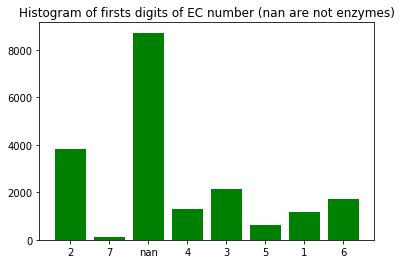

In [4]:
#processing sequences
dicti_padding = {}
for i in list_padding_short:
    dicti_padding[i] = processing_sequences(df_filt, i, max_lenn)
    
# creating binary enzyme/no enzyme label
df_bin = binarizing_EC(df_filt)

#processing enzyme class label
df_digit1 = first_digit_EC(df_bin)

labels_task1 = bin_to_onehot(df_digit1, 2)

ec_multilabel = encoding_as_multilabel(df_digit1, folder)

data_to_hdf5(folder, 'data.h5', list_padding_short, dicti_padding, labels_task1, ec_multilabel)

counting_multilabel(df_digit1)

In [5]:
#splitting indices
splitting_sets = splitting_sets(0.7, 0.5, dicti_padding['post_padding'], ec_multilabel, folder, kfold_bool=True, 
                                n_splits=n_folds)

#creating augmented data
creating_augmented_data(dicti_padding, labels_task1, splitting_sets, folder, 'aug_data.h5', 
                            labels_task2 = ec_multilabel, kfold_bool = True)

# keeping indices enzymes total data
keeping_indices_enzymes(labels_task1, splitting_sets, folder, 'idcs_data_enz.pickle', True)

#keeping indices enzymes aug data
file_data = os.path.join(absPath, 'data/', folder, 'aug_data.h5')
h5f = h5py.File(file_data, 'r')
task2_aug = h5f['labels_task2'][:len(h5f['labels_task2'])]
task1_aug = h5f['labels_task1'][:len(h5f['labels_task1'])]


# Loading splitting indices
file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_aug_split.pickle')

with open(file_idcs, "rb") as input_file:
    k_aug_indices = pickle.load(input_file)

keeping_indices_enzymes(task1_aug, k_aug_indices, folder, 'idcs_aug_enz.pickle', True)

In [6]:
# Loading splitting indices
file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_aug_split.pickle')

with open(file_idcs, "rb") as input_file:
    k_aug_indices = pickle.load(input_file)